In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
torch.cuda.set_device(0)
torch.manual_seed(4)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict

class PlotHelper():
    def __init__(self):
        self.reset()

    def reset(self):
        self._f = None
        self._ax = None
        self.kvals = defaultdict(list)

    def add(self, **kval):
        for k, v in kval.items():
            self.kvals[k].append(v)

    @property
    def fig(self):
        if self._f is None:
            self.new()
        return self._f

    @property
    def ax(self):
        if self._ax is None:
            self.new()
        return self._ax

    def new(self):
        self._f, self._ax = plt.subplots(1,1)
        plt.ion()
        self.fig.show()

    def show(self):
        names = []
        self.ax.clear()
        for k, v in self.kvals.items():
            names.append(k)
            self.ax.plot(v)
        self.ax.legend(names)
        self.fig.canvas.draw()

In [3]:
class SudokuSolver(nn.Module):
    def __init__(self, board_size):
        super().__init__()
        self.W = torch.nn.Parameter(torch.rand((1,6,6,6)))
        
    def __call__(self, X):
        
        return self.W

In [4]:
def process_inputs(X):
    is_input = X.sum(dim=3, keepdim=True)
    
    X = X.view(X.size(0), -1)
    is_input = is_input.view(is_input.size(0), -1)
    
    return is_input

In [5]:
def backward_hook(self, grad_input, grad_out):
    import pdb; pdb.set_trace()

In [6]:
def show_sudoku(X):
    return (torch.argmax(X, 2) + 1) * (X.sum(2).long())

In [7]:
def isvalid_sudoku_row(X):
    return len(X.unique()) == 6

In [8]:
X= torch.tensor([[0, 4, 1, 0, 3, 0],
                 [0, 0, 3, 5, 1, 0],
                 [4, 1, 0, 0, 2, 5],
                 [0, 3, 5, 4, 6, 0],
                 [1, 0, 2, 6, 0, 3],
                 [3, 0, 0, 0, 0, 2]
                 ])

Y= torch.tensor([[5, 4, 1, 2, 3, 6],
                 [6, 2, 3, 5, 1, 4],
                 [4, 1, 6, 3, 2, 5],
                 [2, 3, 5, 4, 6, 1],
                 [1, 5, 2, 6, 4, 3],
                 [3, 6, 4, 1, 5, 2]
                 ])

X_ = torch.zeros((6,6,6))
for i in range(6):
    for j in range(6):
        if X[i][j].item() > 0:
            X_[i][j][X[i][j].item() - 1] = 1        
            
Y_ = torch.zeros((6,6,6))
for i in range(6):
    for j in range(6):
        if Y[i][j].item() > 0:
            Y_[i][j][Y[i][j].item() - 1] = 1
            
X = X_.unsqueeze(0)
Y = Y_.unsqueeze(0)

is_input = process_inputs(X)

In [9]:
# Input
print(show_sudoku(X[0])) # Shape of X_in: (BxHxWxC)

tensor([[0, 4, 1, 0, 3, 0],
        [0, 0, 3, 5, 1, 0],
        [4, 1, 0, 0, 2, 5],
        [0, 3, 5, 4, 6, 0],
        [1, 0, 2, 6, 0, 3],
        [3, 0, 0, 0, 0, 2]])


In [10]:
# Groundtruth
print(show_sudoku(Y[0]))

tensor([[5, 4, 1, 2, 3, 6],
        [6, 2, 3, 5, 1, 4],
        [4, 1, 6, 3, 2, 5],
        [2, 3, 5, 4, 6, 1],
        [1, 5, 2, 6, 4, 3],
        [3, 6, 4, 1, 5, 2]])


In [11]:
import sys
sys.path.append("..")


import torch.optim as optim
from pylon.constraint import constraint
from pylon.sampling_solver import WeightedSamplingSolver

model = SudokuSolver(6)
optimizer = optim.SGD(model.parameters(), lr=1.0)

row_constraint = constraint(isvalid_sudoku_row, WeightedSamplingSolver(num_samples=3000))

In [12]:
from tqdm import tqdm

input = show_sudoku(X[0])
X = X
Y = Y[0]
is_input = is_input[0]    

In [13]:
plot_loss = PlotHelper()
for epoch in tqdm(range(50)):
    row_losses = []
    col_losses = []
    sqr_losses = []

    optimizer.zero_grad()
    
    output = model(X[:1])
    loss = F.cross_entropy(output.view(-1,6), Y.argmax(dim=2).view(-1), reduction='none') * is_input
    
    for i in range(0, 6):
        row_losses += [row_constraint(output[:, i])]
        col_losses += [row_constraint(output[:, :, i])]

    for i in range(0, 6, 2):
        for j in range(0, 6, 3):
            sqr_losses += [row_constraint(output[:, i:i+2, j:j+3].reshape(1,6,6))]
            
    row_losses = torch.stack(row_losses)
    col_losses = torch.stack(col_losses)
    sqr_losses = torch.stack(sqr_losses)
    
    row_multipliers = row_losses / (row_losses.sum().data + col_losses.sum().data + sqr_losses.sum().data)
    col_multipliers = col_losses / (row_losses.sum().data + col_losses.sum().data + sqr_losses.sum().data)
    sqr_multipliers = sqr_losses / (row_losses.sum().data + col_losses.sum().data + sqr_losses.sum().data)
    
    row_loss = (row_losses * row_multipliers).sum()
    col_loss = (col_losses * col_multipliers).sum()
    sqr_loss = (sqr_losses * sqr_multipliers).sum()
    
    total_loss = loss.sum() + row_loss + col_loss + sqr_loss
    recon_loss = (output[0].argmax(dim =-1) != Y.argmax(dim=-1)).sum()
    
    plot_loss.add(loss=loss.mean().data, row_loss=row_loss.data, col_loss=col_loss.data, sqr_loss=sqr_loss.data, recon_loss = recon_loss)

    total_loss.backward()

    optimizer.step()

100%|██████████| 50/50 [03:19<00:00,  4.00s/it]


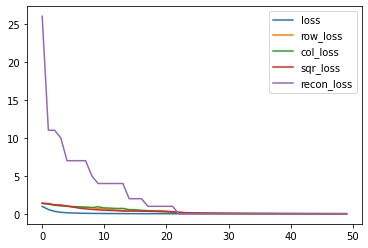

In [14]:
plot_loss.show()

tensor([[5, 4, 1, 2, 3, 6],
        [6, 2, 3, 5, 1, 4],
        [4, 1, 6, 3, 2, 5],
        [2, 3, 5, 4, 6, 1],
        [1, 5, 2, 6, 4, 3],
        [3, 6, 4, 1, 5, 2]])


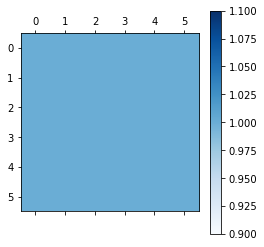

In [15]:
output = model(X[:1])
print((output[0].argmax(dim =-1) + 1).data)
heatmap = plt.matshow((output[0].argmax(dim =-1) == Y.argmax(dim=-1)), cmap=plt.cm.Blues)
plt.colorbar(heatmap)

In [16]:
print(show_sudoku(Y))

tensor([[5, 4, 1, 2, 3, 6],
        [6, 2, 3, 5, 1, 4],
        [4, 1, 6, 3, 2, 5],
        [2, 3, 5, 4, 6, 1],
        [1, 5, 2, 6, 4, 3],
        [3, 6, 4, 1, 5, 2]])
